In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [12]:
def build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [13]:
for i in range(1, 10):
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_30 (B (None, 15976, 8)          32        
_________________________________________________________________
activation_30 (Activation)   (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
_________________________________________________________________
___

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36544/36805 [============================>.] - ETA: 0s - loss: 2.7927 - acc: 0.2032
Epoch 00001: val_loss improved from inf to 2.08284, saving model to model/checkpoint/1D_CNN_BN_DO_1_only_conv_checkpoint/001-2.0828.hdf5
36805/36805 [==============================] - 13s 365us/sample - loss: 2.7896 - acc: 0.2038 - val_loss: 2.0828 - val_acc: 0.3329
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.0085 - acc: 0.3725
Epoch 00002: val_loss improved from 2.08284 to 1.78809, saving model to model/checkpoint/1D_CNN_BN_DO_1_only_conv_checkpoint/002-1.7881.hdf5
36805/36805 [==============================] - 8s 222us/sample - loss: 2.0094 - acc: 0.3722 - val_loss: 1.7881 - val_acc: 0.4396
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7271 - acc: 0.4502
Epoch 00003

Epoch 57/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6099 - acc: 0.7932
Epoch 00057: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 223us/sample - loss: 0.6092 - acc: 0.7934 - val_loss: 1.9583 - val_acc: 0.5225
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6055 - acc: 0.7985
Epoch 00058: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 219us/sample - loss: 0.6054 - acc: 0.7986 - val_loss: 2.0763 - val_acc: 0.5029
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6034 - acc: 0.7976
Epoch 00059: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 218us/sample - loss: 0.6033 - acc: 0.7976 - val_loss: 1.9606 - val_acc: 0.5232
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5959 - acc: 0.7974
Epoch 00060: val_loss did not improve from 1.60176
36805/36805 [========

Epoch 87/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.8154
Epoch 00087: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 221us/sample - loss: 0.5490 - acc: 0.8155 - val_loss: 2.1286 - val_acc: 0.5181
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5505 - acc: 0.8160
Epoch 00088: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 220us/sample - loss: 0.5508 - acc: 0.8158 - val_loss: 2.1133 - val_acc: 0.5199
Epoch 89/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5407 - acc: 0.8187
Epoch 00089: val_loss did not improve from 1.60176
36805/36805 [==============================] - 8s 222us/sample - loss: 0.5409 - acc: 0.8187 - val_loss: 2.0984 - val_acc: 0.5218
Epoch 90/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5443 - acc: 0.8173
Epoch 00090: val_loss did not improve from 1.60176
36805/36805 [========

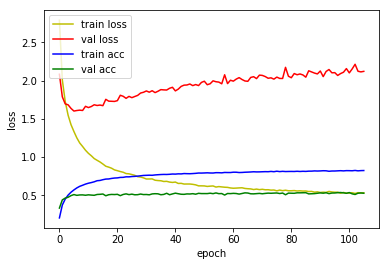

4815/4815 [==============================] - 1s 284us/sample - loss: 1.8043 - acc: 0.4490
Loss: 1.8042701047281362 Accuracy: 0.4490135

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7814 - acc: 0.2001
Epoch 00001: val_loss improved from inf to 1.90158, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/001-1.9016.hdf5
36805/36805 [==============================] - 19s 515us/sample - loss: 2.7803 - acc: 0.2003 - val_loss: 1.9016 - val_acc: 0.3862
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9343 - acc: 0.3847
Epoch 00002: val_loss improved from 1.90158 to 1.52449, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/002-1.5245.hdf5
36805/36805 [==============================] - 11s 301us/sample - loss: 1.9342 - acc: 0.3847 - val_loss: 1.5245 - val_acc: 0.5141
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6377 - a

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7550 - acc: 0.7614
Epoch 00025: val_loss did not improve from 0.96161
36805/36805 [==============================] - 11s 300us/sample - loss: 0.7551 - acc: 0.7614 - val_loss: 0.9723 - val_acc: 0.7109
Epoch 26/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7477 - acc: 0.7647
Epoch 00026: val_loss did not improve from 0.96161
36805/36805 [==============================] - 11s 300us/sample - loss: 0.7472 - acc: 0.7648 - val_loss: 1.0369 - val_acc: 0.6949
Epoch 27/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7318 - acc: 0.7669
Epoch 00027: val_loss improved from 0.96161 to 0.95603, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/027-0.9560.hdf5
36805/36805 [==============================] - 11s 301us/sample - loss: 0.7320 - acc: 0.7667 - val_loss: 0.9560 - val_acc: 0.7235
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5378 - acc: 0.8249
Epoch 00054: val_loss did not improve from 0.94118
36805/36805 [==============================] - 11s 299us/sample - loss: 0.5381 - acc: 0.8248 - val_loss: 0.9554 - val_acc: 0.7317
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5286 - acc: 0.8264
Epoch 00055: val_loss did not improve from 0.94118
36805/36805 [==============================] - 11s 300us/sample - loss: 0.5286 - acc: 0.8263 - val_loss: 1.0714 - val_acc: 0.6923
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5278 - acc: 0.8293
Epoch 00056: val_loss did not improve from 0.94118
36805/36805 [==============================] - 11s 302us/sample - loss: 0.5282 - acc: 0.8292 - val_loss: 0.9776 - val_acc: 0.7314
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5306 - acc: 0.8268
Epoch 00057: val_loss did not improve from 0.94118
36805/36805 [=====

Epoch 113/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.8828
Epoch 00113: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 298us/sample - loss: 0.3519 - acc: 0.8830 - val_loss: 1.0918 - val_acc: 0.7137
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3597 - acc: 0.8825
Epoch 00114: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 301us/sample - loss: 0.3598 - acc: 0.8825 - val_loss: 0.9892 - val_acc: 0.7424
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3544 - acc: 0.8832
Epoch 00115: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 300us/sample - loss: 0.3543 - acc: 0.8834 - val_loss: 1.0353 - val_acc: 0.7205
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3548 - acc: 0.8836
Epoch 00116: val_loss did not improve from 0.93558
36805/36805 [=

Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3039 - acc: 0.9002
Epoch 00143: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 299us/sample - loss: 0.3039 - acc: 0.9001 - val_loss: 0.9829 - val_acc: 0.7482
Epoch 144/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3035 - acc: 0.8990
Epoch 00144: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 302us/sample - loss: 0.3035 - acc: 0.8990 - val_loss: 1.0427 - val_acc: 0.7331
Epoch 145/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3110 - acc: 0.8970
Epoch 00145: val_loss did not improve from 0.93558
36805/36805 [==============================] - 11s 298us/sample - loss: 0.3110 - acc: 0.8971 - val_loss: 0.9736 - val_acc: 0.7503
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3009 - acc: 0.9004
Epoch 00146: val_loss did not improve from 0.93558
36805/36805 [=

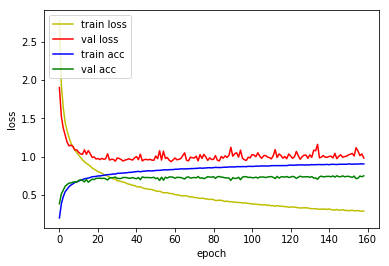

4815/4815 [==============================] - 2s 316us/sample - loss: 1.0973 - acc: 0.6885
Loss: 1.097267709664714 Accuracy: 0.6884735

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.6178 - acc: 0.2159
Epoch 00001: val_loss improved from inf to 1.95258, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/001-1.9526.hdf5
36805/36805 [==============================] - 22s 611us/sample - loss: 2.6169 - acc: 0.2162 - val_loss: 1.9526 - val_acc: 0.3201
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.8290 - acc: 0.4174
Epoch 00002: val_loss improved from 1.95258 to 1.38704, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/002-1.3870.hdf5
36805/36805 [==============================] - 13s 350us/sample - loss: 1.8289 - acc: 0.4174 - val_loss: 1.3870 - val_acc: 0.5623
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5293 - ac

Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3638 - acc: 0.8889
Epoch 00053: val_loss did not improve from 0.50354
36805/36805 [==============================] - 13s 347us/sample - loss: 0.3638 - acc: 0.8889 - val_loss: 0.5341 - val_acc: 0.8493
Epoch 54/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3521 - acc: 0.8928
Epoch 00054: val_loss did not improve from 0.50354
36805/36805 [==============================] - 13s 348us/sample - loss: 0.3522 - acc: 0.8927 - val_loss: 0.5087 - val_acc: 0.8609
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3476 - acc: 0.8940
Epoch 00055: val_loss did not improve from 0.50354
36805/36805 [==============================] - 13s 348us/sample - loss: 0.3477 - acc: 0.8940 - val_loss: 0.5459 - val_acc: 0.8528
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3530 - acc: 0.8918
Epoch 00056: val_loss did not improve from 0.50354
36805/36805 [=====

Epoch 82/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2695 - acc: 0.9146
Epoch 00082: val_loss improved from 0.49024 to 0.47455, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/082-0.4746.hdf5
36805/36805 [==============================] - 13s 352us/sample - loss: 0.2693 - acc: 0.9147 - val_loss: 0.4746 - val_acc: 0.8749
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9173
Epoch 00083: val_loss improved from 0.47455 to 0.47264, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/083-0.4726.hdf5
36805/36805 [==============================] - 13s 347us/sample - loss: 0.2683 - acc: 0.9173 - val_loss: 0.4726 - val_acc: 0.8649
Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2703 - acc: 0.9153
Epoch 00084: val_loss did not improve from 0.47264
36805/36805 [==============================] - 13s 347us/sample - loss: 0.2704 - acc: 0.9153 - val_loss: 0.5026 - va

Epoch 111/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9316
Epoch 00111: val_loss did not improve from 0.46607
36805/36805 [==============================] - 13s 348us/sample - loss: 0.2145 - acc: 0.9316 - val_loss: 0.4810 - val_acc: 0.8782
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2191 - acc: 0.9304
Epoch 00112: val_loss did not improve from 0.46607
36805/36805 [==============================] - 13s 348us/sample - loss: 0.2192 - acc: 0.9304 - val_loss: 0.4851 - val_acc: 0.8714
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2180 - acc: 0.9300
Epoch 00113: val_loss did not improve from 0.46607
36805/36805 [==============================] - 13s 347us/sample - loss: 0.2182 - acc: 0.9300 - val_loss: 0.4701 - val_acc: 0.8793
Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2148 - acc: 0.9312
Epoch 00114: val_loss did not improve from 0.46607
36805/36805 [=

36672/36805 [============================>.] - ETA: 0s - loss: 0.1805 - acc: 0.9422
Epoch 00140: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1807 - acc: 0.9421 - val_loss: 0.4960 - val_acc: 0.8812
Epoch 141/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9414
Epoch 00141: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1841 - acc: 0.9414 - val_loss: 0.5034 - val_acc: 0.8724
Epoch 142/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9421
Epoch 00142: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1857 - acc: 0.9420 - val_loss: 0.5083 - val_acc: 0.8717
Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1839 - acc: 0.9404
Epoch 00143: val_loss did not improve from 0.45023
36805/36805 [===============

Epoch 170/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9511
Epoch 00170: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 349us/sample - loss: 0.1569 - acc: 0.9511 - val_loss: 0.5189 - val_acc: 0.8775
Epoch 171/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1612 - acc: 0.9488
Epoch 00171: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 350us/sample - loss: 0.1613 - acc: 0.9488 - val_loss: 0.5417 - val_acc: 0.8649
Epoch 172/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1586 - acc: 0.9491
Epoch 00172: val_loss did not improve from 0.45023
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1585 - acc: 0.9491 - val_loss: 0.5058 - val_acc: 0.8728
Epoch 173/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1557 - acc: 0.9504
Epoch 00173: val_loss did not improve from 0.45023
36805/36805 [=

Epoch 200/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1387 - acc: 0.9558
Epoch 00200: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1391 - acc: 0.9558 - val_loss: 0.4927 - val_acc: 0.8819
Epoch 201/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1395 - acc: 0.9547
Epoch 00201: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1394 - acc: 0.9547 - val_loss: 0.5022 - val_acc: 0.8775
Epoch 202/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1420 - acc: 0.9552
Epoch 00202: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 345us/sample - loss: 0.1421 - acc: 0.9553 - val_loss: 0.5126 - val_acc: 0.8763
Epoch 203/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1391 - acc: 0.9554
Epoch 00203: val_loss did not improve from 0.44975
36805/36805 [=

Epoch 230/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9599
Epoch 00230: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 349us/sample - loss: 0.1245 - acc: 0.9599 - val_loss: 0.4805 - val_acc: 0.8842
Epoch 231/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9602
Epoch 00231: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 350us/sample - loss: 0.1278 - acc: 0.9602 - val_loss: 0.4896 - val_acc: 0.8833
Epoch 232/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9609
Epoch 00232: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 349us/sample - loss: 0.1253 - acc: 0.9610 - val_loss: 0.5524 - val_acc: 0.8705
Epoch 233/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9589
Epoch 00233: val_loss did not improve from 0.44975
36805/36805 [=

Epoch 260/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1190 - acc: 0.9630
Epoch 00260: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1190 - acc: 0.9630 - val_loss: 0.5334 - val_acc: 0.8812
Epoch 261/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9647
Epoch 00261: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1122 - acc: 0.9647 - val_loss: 0.5126 - val_acc: 0.8784
Epoch 262/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1171 - acc: 0.9625
Epoch 00262: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 347us/sample - loss: 0.1171 - acc: 0.9625 - val_loss: 0.5021 - val_acc: 0.8835
Epoch 263/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9646
Epoch 00263: val_loss did not improve from 0.44975
36805/36805 [=

Epoch 290/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9674
Epoch 00290: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1071 - acc: 0.9674 - val_loss: 0.4617 - val_acc: 0.8931
Epoch 291/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9666
Epoch 00291: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 348us/sample - loss: 0.1026 - acc: 0.9665 - val_loss: 0.5005 - val_acc: 0.8933
Epoch 292/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1047 - acc: 0.9660
Epoch 00292: val_loss did not improve from 0.44975
36805/36805 [==============================] - 13s 349us/sample - loss: 0.1046 - acc: 0.9660 - val_loss: 0.5394 - val_acc: 0.8796
Epoch 293/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9679
Epoch 00293: val_loss did not improve from 0.44975
36805/36805 [=

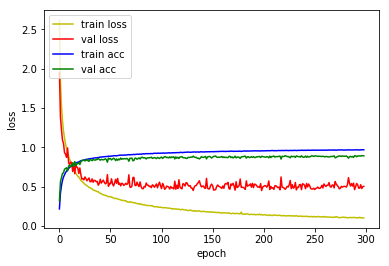

4815/4815 [==============================] - 2s 364us/sample - loss: 0.5562 - acc: 0.8538
Loss: 0.5561911058079293 Accuracy: 0.8537902

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5863 - acc: 0.2200
Epoch 00001: val_loss improved from inf to 1.79158, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/001-1.7916.hdf5
36805/36805 [==============================] - 27s 725us/sample - loss: 2.5862 - acc: 0.2200 - val_loss: 1.7916 - val_acc: 0.4018
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.6182 - acc: 0.4804
Epoch 00002: val_loss improved from 1.79158 to 1.13488, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/002-1.1349.hdf5
36805/36805 [==============================] - 14s 385us/sample - loss: 1.6169 - acc: 0.4807 - val_loss: 1.1349 - val_acc: 0.6560
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2519 - a

36736/36805 [============================>.] - ETA: 0s - loss: 0.3038 - acc: 0.9080
Epoch 00024: val_loss improved from 0.29567 to 0.25957, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/024-0.2596.hdf5
36805/36805 [==============================] - 14s 385us/sample - loss: 0.3039 - acc: 0.9080 - val_loss: 0.2596 - val_acc: 0.9320
Epoch 25/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2947 - acc: 0.9101
Epoch 00025: val_loss did not improve from 0.25957
36805/36805 [==============================] - 14s 381us/sample - loss: 0.2945 - acc: 0.9101 - val_loss: 0.2924 - val_acc: 0.9175
Epoch 26/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2876 - acc: 0.9146
Epoch 00026: val_loss did not improve from 0.25957
36805/36805 [==============================] - 14s 380us/sample - loss: 0.2876 - acc: 0.9147 - val_loss: 0.2906 - val_acc: 0.9122
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2802 - acc:

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1721 - acc: 0.9458
Epoch 00052: val_loss did not improve from 0.22737
36805/36805 [==============================] - 14s 382us/sample - loss: 0.1721 - acc: 0.9458 - val_loss: 0.2914 - val_acc: 0.9185
Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9456
Epoch 00053: val_loss did not improve from 0.22737
36805/36805 [==============================] - 14s 383us/sample - loss: 0.1699 - acc: 0.9456 - val_loss: 0.2567 - val_acc: 0.9276
Epoch 54/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9477
Epoch 00054: val_loss did not improve from 0.22737
36805/36805 [==============================] - 14s 379us/sample - loss: 0.1687 - acc: 0.9477 - val_loss: 0.3040 - val_acc: 0.9087
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1654 - acc: 0.9473
Epoch 00055: val_loss did not improve from 0.22737
36805/36805 [=====

Epoch 80/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9612
Epoch 00080: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 380us/sample - loss: 0.1209 - acc: 0.9612 - val_loss: 0.2759 - val_acc: 0.9236
Epoch 81/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1260 - acc: 0.9593
Epoch 00081: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 386us/sample - loss: 0.1260 - acc: 0.9594 - val_loss: 0.2080 - val_acc: 0.9385
Epoch 82/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9626
Epoch 00082: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 386us/sample - loss: 0.1152 - acc: 0.9626 - val_loss: 0.2743 - val_acc: 0.9278
Epoch 83/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9614
Epoch 00083: val_loss did not improve from 0.19534
36805/36805 [=====

Epoch 110/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9690
Epoch 00110: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 382us/sample - loss: 0.0924 - acc: 0.9691 - val_loss: 0.2368 - val_acc: 0.9362
Epoch 111/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9720
Epoch 00111: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 381us/sample - loss: 0.0889 - acc: 0.9720 - val_loss: 0.2305 - val_acc: 0.9439
Epoch 112/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0903 - acc: 0.9704
Epoch 00112: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 382us/sample - loss: 0.0906 - acc: 0.9703 - val_loss: 0.2018 - val_acc: 0.9448
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9707
Epoch 00113: val_loss did not improve from 0.19534
36805/36805 [=

Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9787
Epoch 00140: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 380us/sample - loss: 0.0678 - acc: 0.9786 - val_loss: 0.2229 - val_acc: 0.9394
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9773
Epoch 00141: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 381us/sample - loss: 0.0729 - acc: 0.9773 - val_loss: 0.2063 - val_acc: 0.9462
Epoch 142/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0662 - acc: 0.9788
Epoch 00142: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 382us/sample - loss: 0.0664 - acc: 0.9788 - val_loss: 0.4502 - val_acc: 0.8910
Epoch 143/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9775
Epoch 00143: val_loss did not improve from 0.19534
36805/36805 [=

Epoch 170/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0579 - acc: 0.9816
Epoch 00170: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 380us/sample - loss: 0.0579 - acc: 0.9816 - val_loss: 0.2316 - val_acc: 0.9383
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9808
Epoch 00171: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 379us/sample - loss: 0.0568 - acc: 0.9808 - val_loss: 0.2190 - val_acc: 0.9439
Epoch 172/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9820
Epoch 00172: val_loss did not improve from 0.19534
36805/36805 [==============================] - 14s 379us/sample - loss: 0.0567 - acc: 0.9819 - val_loss: 0.2512 - val_acc: 0.9441
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9815
Epoch 00173: val_loss did not improve from 0.19534
36805/36805 [=

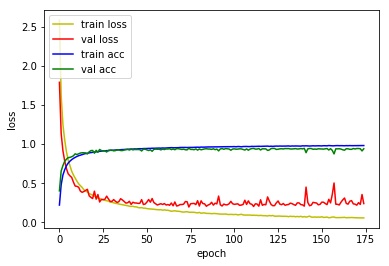

4815/4815 [==============================] - 2s 390us/sample - loss: 0.2656 - acc: 0.9238
Loss: 0.26559395780196937 Accuracy: 0.92377985

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3234 - acc: 0.2957
Epoch 00001: val_loss improved from inf to 1.55178, saving model to model/checkpoint/1D_CNN_BN_DO_5_only_conv_checkpoint/001-1.5518.hdf5
36805/36805 [==============================] - 31s 829us/sample - loss: 2.3233 - acc: 0.2957 - val_loss: 1.5518 - val_acc: 0.4992
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4253 - acc: 0.5412
Epoch 00002: val_loss improved from 1.55178 to 0.99858, saving model to model/checkpoint/1D_CNN_BN_DO_5_only_conv_checkpoint/002-0.9986.hdf5
36805/36805 [==============================] - 15s 420us/sample - loss: 1.4256 - acc: 0.5412 - val_loss: 0.9986 - val_acc: 0.6781
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.0699 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9758
Epoch 00052: val_loss improved from 0.18037 to 0.17716, saving model to model/checkpoint/1D_CNN_BN_DO_5_only_conv_checkpoint/052-0.1772.hdf5
36805/36805 [==============================] - 16s 423us/sample - loss: 0.0765 - acc: 0.9758 - val_loss: 0.1772 - val_acc: 0.9485
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9749
Epoch 00053: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 419us/sample - loss: 0.0798 - acc: 0.9749 - val_loss: 0.1947 - val_acc: 0.9506
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0775 - acc: 0.9751
Epoch 00054: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 419us/sample - loss: 0.0775 - acc: 0.9751 - val_loss: 0.2322 - val_acc: 0.9345
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc:

Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9884
Epoch 00111: val_loss did not improve from 0.17716
36805/36805 [==============================] - 16s 422us/sample - loss: 0.0366 - acc: 0.9885 - val_loss: 0.2469 - val_acc: 0.9448
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9921
Epoch 00112: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 418us/sample - loss: 0.0286 - acc: 0.9920 - val_loss: 0.2260 - val_acc: 0.9495
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9877
Epoch 00113: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 420us/sample - loss: 0.0392 - acc: 0.9877 - val_loss: 0.2094 - val_acc: 0.9529
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9895
Epoch 00114: val_loss did not improve from 0.17716
36805/36805 [=

Epoch 141/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9906
Epoch 00141: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 420us/sample - loss: 0.0310 - acc: 0.9906 - val_loss: 0.2500 - val_acc: 0.9467
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9934
Epoch 00142: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 421us/sample - loss: 0.0232 - acc: 0.9934 - val_loss: 0.2361 - val_acc: 0.9529
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9926
Epoch 00143: val_loss did not improve from 0.17716
36805/36805 [==============================] - 15s 421us/sample - loss: 0.0252 - acc: 0.9926 - val_loss: 0.2291 - val_acc: 0.9497
Epoch 144/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9937
Epoch 00144: val_loss did not improve from 0.17716
36805/36805 [=

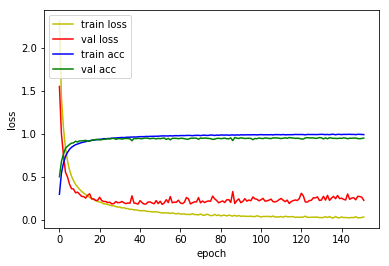

4815/4815 [==============================] - 2s 435us/sample - loss: 0.2204 - acc: 0.9375
Loss: 0.22042345849648196 Accuracy: 0.937487



In [14]:
for i in range(1, 10):
    base = '1D_CNN_only_conv_conv_5_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_DO_BN'

with open(path.join(log_dir, base)) as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, accuracy, loss])+'\n')


1D_CNN_BN_DO_1_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 15976, 8)          32        
_________________________________________________________________
activation_45 (Activation)   (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 31952)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)     

4815/4815 [==============================] - 2s 466us/sample - loss: 0.2656 - acc: 0.9238
Loss: 0.26559395780196937 Accuracy: 0.92377985

1D_CNN_BN_DO_5_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 15976, 8)          32        
_________________________________________________________________
activation_55 (Activation)   (None, 15976, 8)          0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
batch_normalization_v1_56 (B (None, 397